To use a batched A2C we have to adapt both the step method and how we store information for the update.
In particular:
1. Instead of using observations of the environment with everything attached, elaborate the information and extract only the useful variables, so that they can be stacked in numpy arrays when possbile.
2. step method works with observation, but should work with a batch of states and available actions; Probably it will be infeasible to vectorize the selection of the parameters of the actions, because the output and the procedure varies from action to action.
3. The part in which we compute the loss is okay, because we use only the critic to make predictions, so the only problem is to store the information in batches.

NOTE: remember to add all networks to the optimizer initialization

In [1]:
from Utils.train_batched_A2C import *
from Utils import train_batched_REINFORCE as reinf_train
from AC_modules.BatchedA2C import MoveToBeaconSpatialA2C
import AC_modules.Networks as net
import torch

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [3]:
env = init_game(game_params, max_steps=MAX_STEPS)

In [4]:
# Define the two models used in the architecture
model_number = 0
model_names = {0:"FullyConvNet_v0", 1:"FullyConvNet_v1", 2:"FullyConvNet_V2", 3:"ControlNet", 4:"GatedRelationalNet"}

if model_number == 0:
    print(model_names[model_number]+" selected.")
    spatial_model = net.FullyConvSpatial
    nonspatial_model = net.FullyConvNonSpatial
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":2}
    nonspatial_dict = {'resolution':RESOLUTION}
    
elif model_number == 1:
    print(model_names[model_number]+" selected.")
    spatial_model = net.FullyConvSpatial_v1
    nonspatial_model = net.FullyConvNonSpatial_v1
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":3, 'resolution':RESOLUTION}
    nonspatial_dict = {'resolution':RESOLUTION}

elif model_number == 2:
    print(model_names[model_number]+" selected.")
    spatial_model = net.FullyConvSpatial_v2
    nonspatial_model = net.FullyConvNonSpatial_v2
    n_channels = 32
    n_features = 256
    spatial_dict = {"in_channels":6, 'resolution':RESOLUTION}
    nonspatial_dict = {'resolution':RESOLUTION}
    
elif model_number == 3:
    print(model_names[model_number]+" selected.")
    spatial_model = net.SpatialFeatures
    nonspatial_model = net.NonSpatialFeatures
    n_channels = 36
    n_features = 36
    spatial_dict = dict(n_layers=1, linear_size=RESOLUTION, in_channels=6, n_channels=n_features)
    nonspatial_dict = dict(linear_size=RESOLUTION, n_channels=n_features, pixel_hidden_dim=128, pixel_n_residuals=2, 
                 feature_hidden_dim=64, feature_n_residuals=2)
elif model_number == 4:
    print(model_names[model_number]+" selected.")
    spatial_model = net.SpatialFeatures
    nonspatial_model = net.GatedRelationalNet
    n_channels = 32
    n_features = 32
    spatial_dict = dict(n_layers=2, linear_size=RESOLUTION, in_channels=3, n_channels=n_features)

    nonspatial_dict = dict(n_kernels=n_features, n_features=n_features, n_heads=1, n_attn_modules=2, 
                     feature_hidden_dim=16, feature_n_residuals=1)

else:
    print("Model number not available. Choose 0, 1, 2 or 3.")

FullyConvNet_v0 selected.


In [5]:
HPs = dict(action_space=3, gamma=0.99, n_steps=20, H=1e-3, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict)

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

lr = 5e-4
agent = MoveToBeaconSpatialA2C(env=env, **HPs)

Using device cuda


In [6]:
unroll_length = 240

train_dict = dict(n_train_processes = 11,
                  max_train_steps = unroll_length*5000,
                  unroll_length = unroll_length,
                  max_episode_steps = MAX_STEPS,
                  test_interval = unroll_length*10 #100
                  )

In [ ]:
%%time
results = reinf_train.train_batched_A2C(agent, game_params, lr, **train_dict)

Process ID:  SEUJ


In [7]:
%%time
results = train_batched_A2C(agent, game_params, lr, **train_dict)

Process ID:  ZVIX
Step # : 2400, avg score : 0.0
Step # : 4800, avg score : 0.2
Step # : 7200, avg score : 0.2
Step # : 9600, avg score : 0.2
Step # : 12000, avg score : 0.4
Step # : 14400, avg score : 0.4
Step # : 16800, avg score : 0.2
Step # : 19200, avg score : 0.0
Step # : 21600, avg score : 0.2
Step # : 24000, avg score : 0.0
Step # : 26400, avg score : 0.0
Step # : 28800, avg score : 0.4
Step # : 31200, avg score : 0.6
Step # : 33600, avg score : 0.0
Step # : 36000, avg score : 0.0
Step # : 38400, avg score : 0.0
Step # : 40800, avg score : 0.2
Step # : 43200, avg score : 0.0
Step # : 45600, avg score : 0.2
Step # : 48000, avg score : 0.0
Step # : 50400, avg score : 0.0
Step # : 52800, avg score : 0.2
Step # : 55200, avg score : 0.0
Step # : 57600, avg score : 0.0
Step # : 60000, avg score : 0.2
Step # : 62400, avg score : 0.2
Step # : 64800, avg score : 0.2
Step # : 67200, avg score : 0.2
Step # : 69600, avg score : 0.4
Step # : 72000, avg score : 0.0
Step # : 74400, avg score 

Process Process-10:
Process Process-9:
Process Process-2:
Process Process-3:
Process Process-8:
Process Process-5:
Process Process-1:
Process Process-7:
Process Process-6:
Process Process-4:
Process Process-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anac

  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/env/sc2_env.py", line 565, in _step
    return self._observe(target_game_loop=target_game_loop)
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/m/home/home9/94/dainesn1/unix/Workdir/SC2-RL/Utils/train_batched_A2C.py", line 140, in worker
    obs = env.step([data])
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/env/sc2_env.py", line 548, in step
    return self._step(step_mul)
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/multiprocessing/conne

  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/run_parallel.py", line 56, in run
    return [funcs[0]()]
  File "/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/absl/flags/_flag.py", line 114, in value
    return self._value
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/features.py", line 1158, in <listcomp>
    for f in SCREEN_FEATURES]),
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/env/sc2_env.py", line 632, in parallel_observe
    agent_obs = f.transform_obs(obs)
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/env/sc2_env.py", line 632, in parallel_observe
    agent_obs = f.transform_obs(obs)
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/run_parallel.py", line 56, in run
    return [funcs[0]()]
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/protocol.py

  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/remote_controller.py", line 250, in observe
    disable_fog=disable_fog))
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/protocol.py", line 151, in send
    res = self.send_req(req)
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/protocol.py", line 131, in send_req
    return self.read()
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/stopwatch.py", line 212, in _stopwatch
    return func(*args, **kwargs)
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/protocol.py", line 102, in read
    response = self._read()
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/pysc2/lib/protocol.py", line 183, in _read
    response_str = self._sock.recv()
  File "/u/94/dainesn1/unix/.local/lib/python3.7/site-packages/websocket/_core.py", line 314, in recv
    opcode, data = self.recv_data()
  File "/m/work/modules/auto

KeyboardInterrupt: 

Debugging:
1. index sampling -> argument selection -> action selection are okay (x first convention)
2. queued = False works/is selected
3. in test trajectories agent moves coherently all the time
4. on recorded trajectories instead we have strange behaviours sometimes, like it happens that it moves in a direction opposite both to the current and the last action
5. test trajectories are okay also using the step multiplier

In [5]:
#%%time
#torch.cuda.empty_cache()
#results = train_from_checkpoint(agent, game_params, lr, PID="KMNS", step_idx=1280000, **train_dict)

### Models tried:

**FullyConv_v0**
- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
- Non-Spatial network: flatten on pixel dimensions (16x16 -> 256) + linear layer (256 -> 1) with ReLU

We obtain a 32-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 32 -> 256 -> ReLU -> n_actions (3)
- Value net: 32 -> 256 -> ReLU -> 1
- Categorical net: 32 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)

Learning rates tried:
- $10^{-4}$ for 1M+ steps -> nothing
- $5\cdot10^{-5}$ for 2M+ steps -> nothing

n-steps used: 20 ( not 100% sure they were 20 in the first trial, maybe they were 5)

**FullyConv**
- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
- Non-Spatial network: flatten on pixel + channel dimensions (32x16x16 -> 8192) + linear layer (8192 -> 256) with ReLU

We obtain a 256-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 256-> n_actions (3)
- Value net: 256 -> 1
- Categorical net: 256 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)

Learning rates tried:
- $10^{-4}$ for 1M+ steps -> nothing
- $5\cdot10^{-5}$ for 1.2M steps -> slight improvement (from 1.5 to 3 something) - training part 2
- $10^{-3}$ for 2.4M steps -> peak at 1.5M and then drop almost to 0 - 5 steps used

n-steps used: 20 first trial w/ lr 1e-4, now 5 steps

**ResidualConv**
- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
    - residual conv 3x3, padding 1, 32 -> 32 kernels + skip connection
- Non-Spatial network: 
    - flatten on pixel + channel dimensions (32x16x16 -> 8192) 
    - linear layer (8192 -> 256) with ReLU
    - 256 -> LayerNorm-> 64 -> ReLU -> 256 + skip connection and ReLU at the end

We obtain a 256-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 256-> 256 -> ReLU -> n_actions (3)
- Value net: 256 -> 256 -> ReLU -> 1
- Categorical net: 256 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)


**OheNet**
- Spatial network: 
    - 1 conv layer (3x3, padding 1, 24 kernels), 
    - 1 residual conv layer (3x3 padding 1 + skip connection, 24 -> 24 channels)
- Non-Spatial network:
    - 2 residual layers on pixel dim (256 -> LayerNorm -> 128 -> ReLU -> 256 + skip connection)
    - Featurewise maxpool (24,256) -> (24)
    - 2 residual layers on feature dim (32 -> LayerNorm -> 256 -> ReLU -> 32 + skip connection)
    
Same networks for policy, value and categorical parameters. Slightly different for spatial parameters (3x3 conv w/ 1 padding instead of 1x1 conv w/ 0 padding)

Learning rates tried:
- $5\cdot 10^{-5}$ for 1.2M steps -> reward peak at 15 (800k steps) and then collapse to random baseline

In [8]:
score, losses, trained_agent, PID = results

In [9]:
from Utils import utils
save = True
keywords = ['batched-A2C', "conv-net",'lr-7e-4','20-steps', 'no-queued',"1.2M-env-steps","240-unroll-len"] 

if save:
    save_dir = 'Results/MoveToBeacon/'
    keywords.append(PID)
    filename = '_'.join(keywords)
    filename = 'S_'+filename
    print("Save at "+save_dir+filename)
    train_session_dict = dict(game_params=game_params, HPs=HPs, score=score, n_epochs=len(score), keywords=keywords, losses=losses)
    np.save(save_dir+filename, train_session_dict)
    torch.save(trained_agent, save_dir+"agent_"+PID)
else:
    print("Nothing saved")
    pass

Save at Results/MoveToBeacon/S_batched-A2C_conv-net_lr-7e-4_20-steps_no-queued_1.2M-env-steps_240-unroll-len_ESEK


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SpatialActorCritic. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FullyConvSpatial. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__nam

In [10]:
import matplotlib.pyplot as plt
import numpy as np

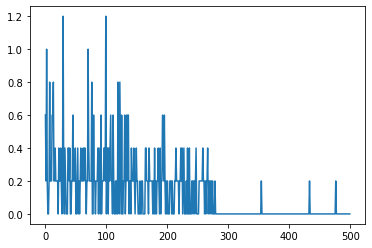

In [11]:
plt.plot(np.arange(len(score)), score)

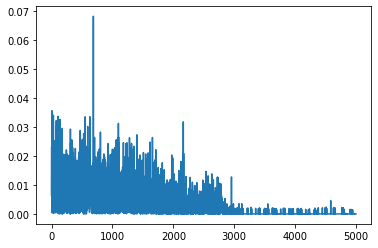

In [12]:
n_epochs = np.arange(len(losses['critic_losses']))
plt.plot(n_epochs, losses['critic_losses'])

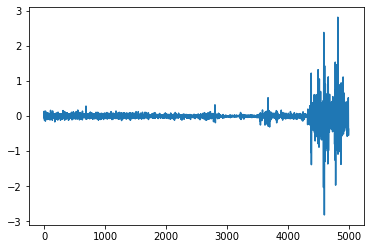

In [13]:
plt.plot(n_epochs, losses['actor_losses'])

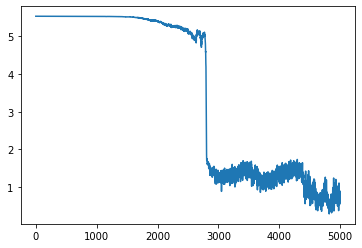

In [14]:
plt.plot(n_epochs, -np.array(losses['entropies']))

# Line by line

In [ ]:
RESOLUTION = 16
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 

In [ ]:
env = init_game(game_params, max_steps=MAX_STEPS)

In [ ]:
HPs = dict(action_space=3, n_layers=2, in_channels=3, n_channels=12, linear_size=RESOLUTION,
           gamma=0.99, n_steps = 20, pixel_n_residuals=2, feature_n_residuals=2)

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

lr = 1e-4
agent = MoveToBeaconSpatialA2C(env=env, **HPs)

In [ ]:
unroll_length = 240

train_dict = dict(n_train_processes = 11,
                  max_train_steps = unroll_length*100,
                  unroll_length = unroll_length,
                  max_episode_steps = MAX_STEPS,
                  test_interval = unroll_length*10 #100
                  )

In [7]:
envs = ParallelEnv(n_train_processes, game_params, max_steps)

reset done
info sent
reset done
info sent


In [8]:
optimizer = torch.optim.Adam(agent.AC.parameters(), lr=lr)

In [9]:
s, a_mask = envs.reset()
print("s.shape: ", s.shape)
print("a_mask.shape: ", a_mask.shape)
print("a_mask: ", a_mask)

s.shape:  (2, 3, 16, 16)
a_mask.shape:  (2, 3)
a_mask:  [[False False  True]
 [False False  True]]


## AC step

To make a batched step we already have the state in the correct shape, but we need to:
1. change get_action_mask of the AC so to work with a list of arrays - DONE
2. sample all parameters every time, so that we don't need to loop between the parameter networks to get the right ones and we can vectorize it
3. select only the parameters that we neeed

Each action has 0, 1 or 2 parameters associated. We should sample a batch of arguments for each parameter of each argument and then access only the correct ones. We need a bit of structure to do that.

(batch_dim, [[params0],[params1],[params2]])
and same thing for the log_prob

Unfortunately we get something like ([[],[(batch_dim, args)],[(batch_dim, arg1),(batch_dim, arg2)]])

In [10]:
action, log_prob, probs = agent.step(s, a_mask)


action mask:  tensor([[False, False,  True],
        [False, False,  True]], device='cuda:0')
logits shape:  torch.Size([2, 3])
logits:  tensor([[-1.6008, -0.7392, -1.1371],
        [-1.7987, -0.6966, -1.0900]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
mask shape:  torch.Size([2, 3])
mask:  tensor([[False, False,  True],
        [False, False,  True]], device='cuda:0')
logits (after mask):  tensor([[-1.6008, -0.7392,    -inf],
        [-1.7987, -0.6966,    -inf]], device='cuda:0',
       grad_fn=<IndexPutBackward>)
log_probs:  tensor([[-1.2141, -0.3524,    -inf],
        [-1.3889, -0.2868,    -inf]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
spatial_features.shape:  torch.Size([2, 12, 16, 16])
spatial_features (cuda):  True
nonspatial_features.shape:  torch.Size([2, 12])
nonspatial_features (cuda):  True
probs:  tensor([[0.2970, 0.7030, 0.0000],
        [0.2493, 0.7507, 0.0000]], device='cuda:0', grad_fn=<ExpBackward>)
log_prob:  tensor([-0.3524, -0.2868], dev

In [11]:
s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(action)


In [13]:
print("s_prime.shape; ", s_prime.shape)
print("r.shape: ", r.shape)
print("done.shape: ", done.shape)
print("bootstrap.shape: ", bootstrap.shape)
print("s_trg.shape: ", s_trg.shape)
print("a_mask.shape: ", a_mask.shape)

s_prime.shape;  (2, 3, 16, 16)
r.shape:  (2,)
done.shape:  (2,)
bootstrap.shape:  (2,)
s_trg.shape:  (2, 3, 16, 16)
a_mask.shape:  (2, 3)


In [16]:
#print("s_prime: ", s_prime)
print("r: ", r)
print("done: ", done)
print("bootstrap: ", bootstrap)
#print("s_trg: ", s_trg)
print("a_mask: ", a_mask)

r:  [0 0]
done:  [False False]
bootstrap:  [False False]
a_mask:  [[False False False]
 [False False False]]


In [15]:
action, log_prob, probs = agent.step(s_prime, a_mask)


action mask:  tensor([[False, False, False],
        [False, False, False]], device='cuda:0')
logits shape:  torch.Size([2, 3])
logits:  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
mask shape:  torch.Size([2, 3])
mask:  tensor([[False, False, False],
        [False, False, False]], device='cuda:0')
logits (after mask):  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<IndexPutBackward>)
log_probs:  tensor([[-1.6421, -0.7365, -1.1158],
        [-1.7094, -0.7659, -1.0381]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
spatial_features.shape:  torch.Size([2, 12, 16, 16])
spatial_features (cuda):  True
nonspatial_features.shape:  torch.Size([2, 12])
nonspatial_features (cuda):  True
probs:  tensor([[0.1936, 0.4788, 0.3277],
        [0.1810, 0.4649, 0.3541]], device='cuda:0', grad_fn=<ExpBackward>)
log_prob:  tensor([-0.7365, -1.0381], dev

In [17]:
s_prime, r, done, bootstrap, s_trg, a_mask = envs.step(action)

In [19]:
envs.close()

In [15]:
import torch
import torch.nn.functional as F

In [26]:
logits = torch.rand((2,3), requires_grad=True)
mask = torch.tensor([[False, False, True], [False, False, True]])
x = F.log_softmax(logits.masked_fill((mask).bool(), float('-inf')), dim=-1) 

In [28]:
x.sum().backward()